In [30]:
# Load the installed packages
using Distributions
using Turing
using StatisticalRethinking
using Random, MCMCChains
using LinearAlgebra, Statistics, StatsBase; 
using MultivariateStats
using DataFrames
using CSV
using Statistics
using StatsPlots
using LinearAlgebra, Statistics, StatsBase, Plots; 

## Problem 1
$$
g(\mu, \sigma^{2}, x1 | data) \propto \frac{1}{\sigma^2} exp{(-\frac{(y_i-\mu)^2}{2\sigma^2})} \times \frac{1}{\sqrt{2 \pi \sigma^2}}exp{(-\frac{(x_1-\mu)^2}{2\sigma^2})}
$$


To solve this we will follow the solution provided by Valen E.Johson, James H.Albert in the book Ordinal Data Modeling. The steps are:

1. Given current values of µ and σ 2 , simulate a value of the censored observation
x 1 from a normal N (µ, σ 2 ) distribution, truncated below by the censoring value provided.
2. Use the simulated values of the actual data generated in the above step to form
a complete dataset x 1 , ..., x n . Simulate new values of the normal parameters µ
and σ2 from the normal/inverse gamma distribution.
This cycle is iterated a large number of times, storing the simulated values of
the parameters at the end of each cycle. Graphical inspection of the sequence of
the simulated values for µ and σ 2 indicates that the algorithm converges quickly,
and so not too many iterations are required before the sampled values of µ and σ 2
might be regarded as samples from the posterior.

For this we will use the normal distribution for µ and σ 2

Conditional Posterior Distributions
$$
P(\mu, \sigma^2 | x1) \sim  \mathcal{N} (\mu, \sigma^2)
$$

$$
    P(x1 | \mu, \sigma^2) \sim \mathcal{N} (\mu, \sigma^2) \quad for \quad 110 \leq  x_1 \leq \infty
$$



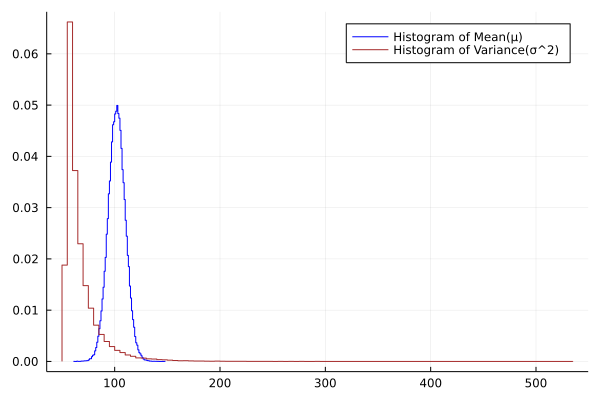

In [2]:
function bigibbs(dataset, T, c)
    y = Vector{Float64}(dataset)
    push!(y, c)
    new_var = var(y) #taking prior variance of dataset
    new_mu = rand(Normal(mean(y), sqrt(new_var)), 1) #calculating or generating a mean based on the dataset
    new_mu = new_mu[1,1]
    mu = ones(T) #creating an array/vector of size T which contains one.
    sigma = ones(T) #creating an array/vector of size T which contains one.
    for t = 1:T
        d = truncated(Normal(new_mu, sqrt(new_var)), c, Inf) # for calculating x1 from from MU and Var
        x1 = rand(d, 1) # with truncated normal distribution with lower limit C (110), and taking a random variable
        new_y = Vector{Float64}(dataset) 
        push!(new_y, x1[1,1]) 
        mu_y = mean(new_y) #using or creating that same dataset with the new x1 and finding mean
        new_var = var(new_y) # getting the new var
        new_mu = rand(Normal(mu_y, sqrt(new_var)), 1) #using the mean and var to find out the new mean
        new_mu = new_mu[1,1]  
        mu[t] = new_mu # storing the new mean
        sigma[t] = new_var #storing the variance
    end
    return mu, sigma
end

data = [104,98,101,105,97,106, 107,84,104] # rest of the value of the dataset.
c = 110 
#taking the first value which is C here, or the lowest value x1 can reach, later using it for truncated normal distribution

## example

MU,Sigma2=bigibbs(data, 100000,c)
stephist(MU, bins=100, c=:blue, normed=true, label="Histogram of Mean(μ)")
stephist!(Sigma2, bins=100, c=:brown, normed=true, label="Histogram of Variance(σ^2)")

In [3]:
mu_5 = quantile(MU, 0.05)
mu_95 = quantile(MU, 0.95)

sigma2_5 = quantile(Sigma2, 0.05)
sigma2_95 = quantile(Sigma2, 0.95)

println("The 90% interval of the estimate of mu is from: ", mu_5, " to: ", mu_95)
println("The 90% interval of the estimate of sigma is from: ", sqrt(sigma2_5), " to: ", sqrt(sigma2_95))

The 90% interval of the estimate of mu is from: 88.60762307482435 to: 115.62216399265417
The 90% interval of the estimate of sigma is from: 7.384806272695183 to: 10.054361007108144


## Problem 2: 

For problem two we will do metropolis hasting algorithm, which allows us to sample from a generic probability distribution even if we do not know the normalizing constant. The idea is to use Markonchain with arbitary starting value and then iteratively accepting and rejecting candit samples, drawn from another distributions that is easy to sample from. Here we have the posterior distribution. 

The posterior distribution is given by:

$$
p(\theta) = 0.6e^{-\frac{\theta^2}{2}} + 0.2e^{-\frac{(\theta-3)^2}{8}}
$$

Proposal Distribution is given by:$$ \mathcal{N}(x\,;\,\mu,\sigma)=\, \frac{1}{\sigma (2\pi)^{\frac{1}{2}}} exp\big[ -\frac{(x-\mu)}{2\sigma^2}\big]^2 $$

We also have to set the burn in period because, it will take a number of samples before reaching the steady state of Markov Chain, which here will be 10^5. Moreover, we will sample from the previous distribution with some fixed variance, \sigma^2. Also, we are going to find the ratio of the new sample divide it by the old same and mulitply with the proposal value of the old sample and divide by the new sample. Then, we will try to find the value of the minimum value, with our acceptance criteria and see if it is within. If it is, we store the sample. However, it is done after the burning period, where we know we have reached the transition period.

MCMC Bayes Estimate: 1.4545321582801995


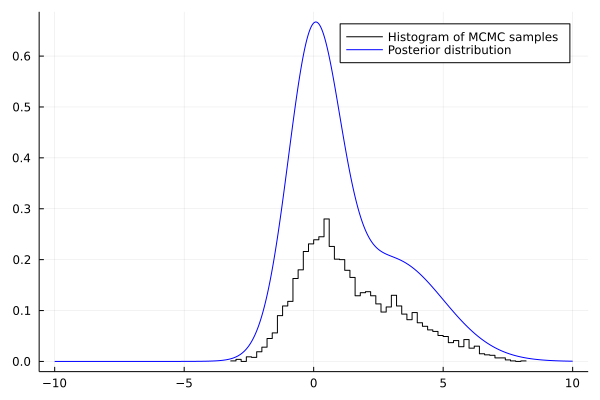

In [4]:

posteriorUpToK(theta) = 0.6*exp(-(theta^2)/2) + 0.2*exp(-(theta-3)^2/8) # posterior distribution

sig = 0.5 #SETTING UP A KNOWN VARIANCE AND UNKNOWN MEAN
foldedNormalPDF(x,mu) = (1/sqrt(2*pi*sig^2))*(exp(-(x-mu)^2/2sig^2)) # proposal distribution
foldedNormalRV(mu) = rand(Normal(mu,sig)) # obtain z* from a distribution of known mu and sigma

function sampler(piProb,qProp,rvProp)
    theta = 1
    warmN, N = 10^5, (10^5 + 5000)
    samples = zeros(N-warmN)

    for t in 1:N
        while true
            thetaTry = rvProp(theta)
            L = piProb(thetaTry)/piProb(theta) #finding the ratio posterior (b) / posterior (a)
            H = min(1,L*qProp(theta,thetaTry)/qProp(thetaTry,theta)) # product times the both proposal distribution
            # here we could also just used  L = piProb(thetaTry)/piProb(theta), for the acceptance criteria, as we 
            # trying to generate samples for a symmetric distribution.
            if rand() < H
                theta = thetaTry
                if t > warmN
                    samples[t-warmN] = theta
                end
                break
            end
        end
    end
    return samples
end

mcmcSamples = sampler(posteriorUpToK,foldedNormalPDF,foldedNormalRV)
println("MCMC Bayes Estimate: ",mean(mcmcSamples))

stephist(mcmcSamples, bins=100, c=:black, normed=true, label="Histogram of MCMC samples")

thetaRange = -10:0.01:10
plot!(thetaRange, posteriorUpToK.(thetaRange), c=:blue, label="Posterior distribution")

Here, we can see the stephistogram, which shows the sample which has been accepted and falls within the acceptance ration. As we can see, the histogram of the MCMC samples does have the same shape, however, does not entirely reach the borders points of the posterior graph, this is because the ratio there is greater and does not fall within the acceptance criteria, as it reaches the borders the chance of acceptance does get slimer.

In [5]:
posteriorUpToK(theta) = 0.6*exp(-(theta^2)/2) + 0.2*exp(-(theta-3)^2/8)


posteriorUpToK (generic function with 1 method)

The posterioir can be written down as a mixture model/ multimodel distribution, consisting of two normal distributions with weights. For the first one we consider mean zero and variance 1. For the second one we consider mean 3 and variance 2, with the weights 0.6 and 0.2. However, for the apis to be working, the weights must be scared to 1. Therefore, we represent 0.6 as 0.75 out of 1 and 0.25 out of 1.

$$
distribution 1 \sim 0.6e^{-\frac{(\theta-0)^2}{2*1^2}} 
$$


$$
distribution 2 \sim 0.2e^{-\frac{(\theta-3)^2}{2*2^2}} 
$$


In [6]:
@model posterior_model() = begin

    x ~ MixtureModel(Normal[
            Normal(0.0, 1.0),
            Normal(3.0, 2.0)], [0.75, 0.25])
end 

posterior_model (generic function with 1 method)

Sampling using Metropolis Hasting Algorithm, creating 3 chains, with 105000 number of samplers. Here we are using the default proposal distribution provided by MH(), which is normal distribution. 

In [7]:
chain=mapreduce(c -> sample(posterior_model(),  MH(), 105000),
    chainscat,
    1:3
);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


In [8]:
plot(chain)

If we see the value of x which is basically the theta for the posterior distribution, the sampling has been completely random, which means that the sampling did not become stagnant and it was trying to sample from all parts of the distribution, which created almost a bell shaped curve.

In [9]:
chain

Chains MCMC chain (105000×2×3 Array{Float64, 3}):

Iterations        = 1:1:105000
Number of chains  = 3
Samples per chain = 105000
parameters        = x
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse           ess      rhat 
      Symbol   Float64   Float64    Float64   Float64       Float64   Float64 

           x    0.7475    1.8477     0.0033    0.0033   314811.5998    1.0000

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           x   -1.8674   -0.4677    0.3486    1.4528    5.5490


┌ Warning: timestamp of type Nothing unknown
└ @ MCMCChains /home/itachiuchiha/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364
┌ Warning: timestamp of type Nothing unknown
└ @ MCMCChains /home/itachiuchiha/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364
┌ Warning: timestamp of type Nothing unknown
└ @ MCMCChains /home/itachiuchiha/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/itachiuchiha/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/itachiuchiha/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/itachiuchiha/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364
┌ Warning: timestamp of type Nothing unknown
└ @ MCMCChains /home/itachiuchiha/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364
┌ Warning: timestamp of type Nothing unknown
└ @ MCMCChains /home/itachiuchiha/.julia/pack

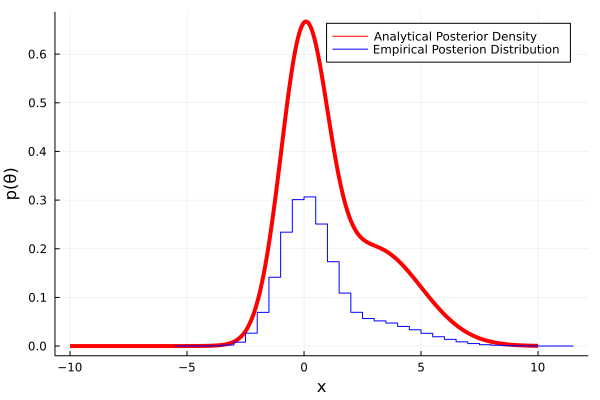

In [10]:
#Draw posterior distribution
burnin=100000
p_summary = chain[:x][burnin:end]
xGrid = -10:0.01:10

plot( xGrid,  posteriorUpToK.(xGrid), c=:red, lw=4, xlabel="x", label="Analytical Posterior Density", ylabel = "p(θ)", legend=:topright)
stephist!(p_summary, xlabel="x", color=:blue, bins=40, normed=true, label="Empirical Posterion Distribution")

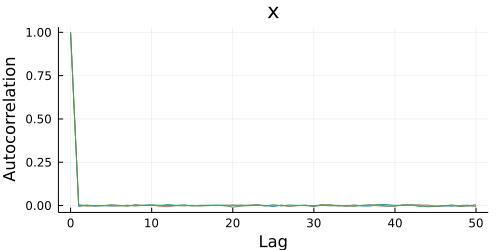

In [11]:
autocorplot(chain)

In [12]:
gelmandiag(chain)

Gelman, Rubin, and Brooks Diagnostic
  parameters      psrf     97.5% 
      Symbol   Float64   Float64 

           x    1.0000    1.0001


We are seeing the autocorplot of the samples generated by the chains, as we can see the value instantly reaches zero therefore, it was a good chain. Therefore, we can say that the samples are not dependent on one another. Also the effective sample size (ESS) is 314449.8719, out of (105000*3). Which shows how much effective samples we have out of the metropolis hastings sampler. This is the number of samples without correlation. Also, if we see the value of RHAT, which is one, shows that the chains have corverged and the variation between them is zero, also within the chain the variation is zero. This shows that the sampling has been random and good.

In [13]:
println("MCMC Bayes Estimate: ",mean(p_summary))

MCMC Bayes Estimate: 0.7486874697589726


The sampling with turing is pretty safe, and the chances of mistakes are low. Likewise, when implementing the algorithm there is a chance for mistakes. However, with Turing it is not possible to sample using an abstract model. For example, to implement this posterior distribution we had to rescale the weights for computing with the apis. Likewise, when tried with other packages of Turing like AdvancedMH, the sampling was not random, the autocorrelation plot took a look of time to come to zero. Therefore, defining the abstract posterior cannot be exact with Turing, that is a shortcoming of this packages. Likewise, the results are a bit scaled. And best part about implementing the MH, algorithm ourselves is that, it gives the freedom for us to make any sort of changes we want. In conclusion, both sampling technique converged and both provided a decent distribution with our proposal distribution. As discussed there are advantages and disadvantages.

## Problem 3.

Here, we are implementing variational inference to infer the latent variables of a Guassian Mixture Model, based on https://github.com/AM207/2018fall/blob/master/wiki/VI.ipynb. 

We'll restrict ourselves to a bayesian mixture of unit-variance univariate Gaussians -

Assume there are K mixture components corresponding to K normal distributions where the K independent means are drawn from a Gaussian prior with zero mean and fixed variance (can be assumed to be a hyperparameter).
For each observation i, we first choose a cluster assignment that indicates which one of the K clusters the observation comes from. This is defined by a categorical distribution with uniform density. We then draw the observation from the corresponding Gaussian mixture component.

$$ \boldsymbol{\mu} = \{\mu_1, ..., \mu_K\},
    \mu_k \sim \mathcal{N}(0, \sigma^{2}), \hspace{1cm} k = 1, ..., K,
    c_i \sim Categorical(\frac{1}{K}, ..., \frac{1}{K}), \hspace{1cm} i = 1, ..., n,
    x_i \vert c_i, \boldsymbol{\mu} \sim \mathcal{N}(c_i^T\boldsymbol{\mu}, 1), \hspace{1cm} i = 1, ..., n
 $$


The joint distribution over n observations and the latent variables can be given by -

$$ 
p(\boldsymbol{\mu, c, x}) = p(\boldsymbol{\mu})\boldsymbol{\prod_{i=1}^{n}}p(c_i)p(x_i \vert c_i,\boldsymbol{\mu}) $$
    
and the evidence can thus be calculated as:
    $$
    p(\boldsymbol{x}) = \int d\boldsymbol{\mu} p(\boldsymbol{\mu})\prod_{i=1}^n \sum_{c_i} p(c_i) p(x_i \vert c_i, \boldsymbol{\mu})
    $$
    
    
This integral does not teduce to a product of 1-d integrals for each of the $\mu$.



and the evidence can thus be calculated as:


The latent variables are the K class means and the n class assignments -

 $$ \boldsymbol{z} = \{\boldsymbol{\mu, c}\} $$

Now, we specify the mean-field variational family to approximate our Bayesian posterior distributions. Next, we derive the CAVI update for the variatonal factors.

We first start with the update for the cluster assignment factor.

We separate the terms that depend on the cluster assignment vs those that don't. We then compute the expectation with respect to the remaining variational factors.



Here, the dataset is already provided and assigned to a specific cluster which represents the guassian mixture. We will take the dataset and plot the dataset according to the clusters. Here there are 3 clusters

In [58]:
data = DataFrame(CSV.File("data.csv", transpose=true, header=false))
N = DataFrame(CSV.File("N.csv", transpose=true, header=false))

1000×1 DataFrame
│ Row  │ Column1 │
│      │ Int64   │
├──────┼─────────┤
│ 1    │ 1       │
│ 2    │ 1       │
│ 3    │ 1       │
│ 4    │ 1       │
│ 5    │ 0       │
│ 6    │ 0       │
│ 7    │ 2       │
│ 8    │ 2       │
│ 9    │ 0       │
│ 10   │ 1       │
⋮
│ 990  │ 2       │
│ 991  │ 0       │
│ 992  │ 0       │
│ 993  │ 1       │
│ 994  │ 0       │
│ 995  │ 1       │
│ 996  │ 0       │
│ 997  │ 1       │
│ 998  │ 2       │
│ 999  │ 0       │
│ 1000 │ 1       │

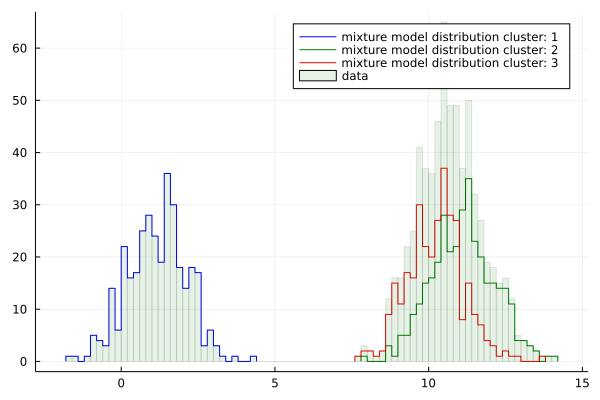

In [59]:
# hyperparameters 
# we set up a fixed variance for the models.
prior_std = 10

# True parameters
K = 3

# Plot variables
color_types = Vector{String}(["blue", "green", "red", "magenta", "yellow"])

data_resp = Dict{Int64, Vector{Float64}}() # where we keep the clusters data with the keys.

n = length(N[:,1])
K = 3

plot_curve = plot()

data_1d = data[:,1]

for i in 1:n
    if haskey(data_resp, N[i,1] + 1)
        push!(data_resp[N[i,1] + 1], data_1d[i])
    else
        data_resp[N[i,1] + 1] = Vector{Float64}([data_1d[i]])
    end
end



for k in 1:K
    label = string("mixture model distribution cluster: ",k)
    stephist!(data_resp[k], color=color_types[k,1], bins=30, label=label)
end
histogram!(data_1d[:], color="Green", bins=90, alpha=0.1, label="data")
display(plot_curve)

Here we can see how the clusters are representing the dataset, some of the dataset is outside the distribution. However, that seems to be not much of a concern, because the clusters are around the dataset.

In [60]:
n = length(N[:,1])

println(typeof(n))

Int64


In variational inference, the goal is to minimise the KL-divergence from the variational distribution to the true posterior. As we are trying to fit a distribution on the data but we do not know what that distribution is, what we only know is that it is a mixture of three distributions. So we assume that this mixture is a Guassian, and try to minimize the KL divergence between our distribution and the actual data until we find the latent variables which are the parameters of the guassian mixtures.

In [61]:
#Variational Inference - CAVI
function VI(K, prior_std, n, data_ref)
    mu_mean = Vector{Float64}()
    mu_var = Vector{Float64}()
    
    for i in 1:K
        push!(mu_mean, rand(Normal(0, prior_std)))
        push!(mu_var, abs(rand(Normal(0, prior_std))))
    end
  
    c_est = zeros(n, K)
        
    for i in 1:n
        c_est[i, rand(1:K)] = 1
    end
    

    #Initiate CAVI iterations
    while true
        mu_mean_old = mu_mean[:]
        
        #mixture model parameter update step
        for j in 1:K
            nr = 0 
            dr = 0 
            for i in 1:n
                nr = nr + c_est[i,j] * data_ref[i]
                dr = dr + c_est[i,j] 
            end
            mu_mean[j] = nr / ((1/prior_std^2) + dr)
            mu_var[j] = 1.0 / ((1/prior_std^2) + dr)
        end
        
        # categorical vector update step
        for i in 1:n
            cat_vec = Vector{Float64}()
            for j in 1:K
                push!(cat_vec, exp(mu_mean[j]*data_ref[i] - (mu_var[j] + mu_mean[j]^2)/2))
            end
            for k_index in 1:K
                c_est[i,k_index] = cat_vec[k_index] / sum(cat_vec)
            end
        end 
        
        # compute ELBO or check for convergence of variational factors - here we do the latter
        if dot((mu_mean_old - mu_mean) , (mu_mean_old - mu_mean) ) < 0.000001
            break 
        end
    
    end 
    # sort the values since the k mixture components dont maintain any ordering across multiple initializations
    # combine the mean and the variance that was computed
    mixture_components = hcat(mu_mean, mu_var)
    mixture_components = sortslices(mixture_components, dims = 1, by=x->(x[1]))
    
    return mixture_components, c_est
end



VI (generic function with 1 method)

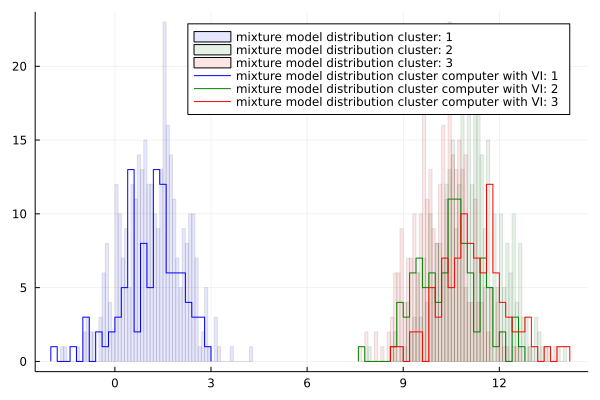

Mixture component computed by VI and their with variance[1.1689206428108856 0.0029939223442579698; 10.318444857089126 0.0029955696920537477; 11.043369821056363 0.0030102920415224473]
Actual Mixture component mean and their with variance: 1.1689556467065867, 0.9035553163627997
Actual Mixture component mean and their with variance: 11.096175925072044, 1.0380916920354681
Actual Mixture component mean and their with variance: 10.228003435736676, 0.8439103709383723


In [62]:
n = 1000
mixture_components, c_est = VI(K, prior_std, n, data_1d)
plot_curve = plot()

println( "Mixture component computed by VI and their with variance", mixture_components)

for k in 1:K
    label = string("mixture model distribution cluster: ",k)
    println( "Actual Mixture component mean and their with variance: ", mean(data_resp[k]), ", " , var(data_resp[k]))

    histogram!(data_resp[k], color=color_types[k,1], bins=90, alpha=0.1 , label=label)
end


for k in 1:K
    label = string("mixture model distribution cluster computer with VI: ",k)
    vals=rand(Normal(mixture_components[k][1], 1), 100)
    stephist!(vals,  color=color_types[k,1], bins=30, label = label);
end
display(plot_curve)

Here, the histrogram represents the clusters that was provided to us of the mixtures, after computing with VI, we can see the step histogram which represents the mixture model distribution computed with Variational Inference. As we can see the distribution does fit the clusters and the means are very near to the actual value however, the variances are not. Therefore, even though not completely perfect but can be said a fair and good result.

Now we will try to implement the same thing using Turing. For that we need to define a model and use that model to call the Variational Inference api.

In [92]:
@model function gmm(x, K)
    N = length(x)
    μ ~ filldist(Normal(0,1), K)
    w ~ Dirichlet(K, 1)
    x ~ arraydist(map(i -> MixtureModel(Normal, μ, w), 1:N))
end

gmm (generic function with 1 method)

As we already know that there will be three clusters therefore, we are defining a model with 3 clusters. 

In [89]:
@model GaussianMixtureModel(x) = begin
    
    D, N = size(x)
    
    prior_std = 10

    # Draw the parameters for cluster 1.
    μ1 ~ Normal()
    
    # Draw the parameters for cluster 2.
    μ2 ~ Normal()
    
    # Draw the parameters for cluster 3.
    μ3 ~ Normal()
    
    μ = [μ1, μ2, μ3]
    
    # Uncomment the following lines to draw the weights for the K clusters 
    # from a Dirichlet distribution.
    
    α = 1.0
    w ~ Dirichlet(3, α)
    
    # Comment out this line if you instead want to draw the weights.
    #w = [0.5, 0.5]
    
    # Draw assignments for each datum and generate it from a multivariate normal.
    k = Vector{Int}(undef, N)
    for i in 1:N
        k[i] ~ Categorical(w)
        x[:,i] ~ MvNormal([μ[k[i]], μ[k[i]], μ[k[i]]], 1.)
    end
    return k
end

GaussianMixtureModel (generic function with 1 method)

In [93]:
mixture_model = gmm(data_1d, K);
# mixture_model = GaussianMixtureModel(data_1d)

In [94]:
advi = ADVI(10, 1000)
q = vi(mixture_model, advi)

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 11827570222885762911
└ @ AdvancedVI /home/itachiuchiha/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:199
[ADVI] Optimizing...100% Time: 0:00:39


MultivariateTransformed{DistributionsAD.TuringDiagMvNormal{Vector{Float64}, Vector{Float64}}, Stacked{Tuple{Identity{1}, Inverse{Bijectors.SimplexBijector{1, true}, 1}}, 2}}(
dist: DistributionsAD.TuringDiagMvNormal{Vector{Float64}, Vector{Float64}}(
m: [6.492863772837953, 7.182544358604837, 6.154534635862395, -0.08052807678505593, 0.12247214735230941, -0.3930179142507364]
σ: [3.4814822756923975, 3.3637269428407692, 3.7319509397317003, 0.08510587467440128, 0.07165049907257494, 7.41722027964264]
)

transform: Stacked{Tuple{Identity{1}, Inverse{Bijectors.SimplexBijector{1, true}, 1}}, 2}((Identity{1}(), Inverse{Bijectors.SimplexBijector{1, true}, 1}(Bijectors.SimplexBijector{1, true}())), (1:3, 4:6))
)


I apologize professor, I could not understand how Turing works for this part. 